<!-- ---
reviewed_on: "2024-11-20"
--- -->

# Inference and validation

## Import necessary packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from torch import nn, optim

## Loading the dataset

In [ ]:
from torchvision import datasets, transforms


transform = transforms.Compose([transforms.ToTensor(),
								transforms.Normalize((0.4919, 0.4827, 0.4472),
														(0.2022, 0.1994, 0.2010)),
								])

trainset = datasets.CIFAR10("~/.pytorch/CIFAR-10/", download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = datasets.CIFAR10("~/.pytorch/CIFAR-10/", download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
classes = [
			"airplane",
			"automobile",
			"bird",
			"cat",
			"deer",
			"dog",
			"frog",
			"horse",
			"ship",
			"truck"
		]

## Building the network

In [4]:
input_size = 3072
output_size = 10

In [5]:
hidden_sizes = [1024, 512, 256]

In [6]:
class Network(nn.Module):
	def __init__(self):
		super().__init__()

		self.fc1 = nn.Linear(input_size, hidden_sizes[0])
		self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
		self.fc3 = nn.Linear(hidden_sizes[1], hidden_sizes[2])
		self.fc4 = nn.Linear(hidden_sizes[2], output_size)

		self.dropout = nn.Dropout(p=0.2)

	def forward(self, x):
		x = x.view(x.shape[0], -1)

		x = self.dropout(F.relu(self.fc1(x)))
		x = self.dropout(F.relu(self.fc2(x)))
		x = self.dropout(F.relu(self.fc3(x)))

		x = F.log_softmax(self.fc4(x), dim=1)

		return x

## Loading the trained network

In [ ]:
state_dict = torch.load("checkpoint.pth")
saved_network = Network()

saved_network.load_state_dict(state_dict)

## Training the network

In [7]:
network = Network()
optimizer = optim.Adam(network.parameters(), lr=0.0001)
criterion = nn.NLLLoss()

In [8]:
epochs = 1

train_losses, test_losses = [], []
for e in range(epochs):
	running_loss = 0
	for images, labels in trainloader:
		optimizer.zero_grad()

		log_ps = network(images)
		loss = criterion(log_ps, labels)
		loss.backward()
		optimizer.step()

		running_loss += loss.item()
	else:
		test_loss = 0
		accuracy = 0

		# Turn off gradients for validation, saves memory and computations
		with torch.no_grad():
			network.eval()
			for images, labels in testloader:
				log_ps = network(images)
				test_loss += criterion(log_ps, labels)

				ps = torch.exp(log_ps)
				top_p, top_class = ps.topk(1, dim=1)
				equals = top_class == labels.view(*top_class.shape)
				accuracy += torch.mean(equals.type(torch.FloatTensor))

		network.train()

		train_losses.append(running_loss / len(trainloader))
		test_losses.append(test_loss / len(testloader))

		print("Epoch: {}/{} ".format(e + 1, epochs),
				"Training Loss: {:.3f} ".format(train_losses[-1]),
				"Test Loss: {:.3f} ".format(test_losses[-1]),
				"Test Accuracy: {:.3f} ".format(accuracy / len(testloader)))

Epoch: 1/1  Training Loss: 1.732  Test Loss: 1.523  Test Accuracy: 0.464 


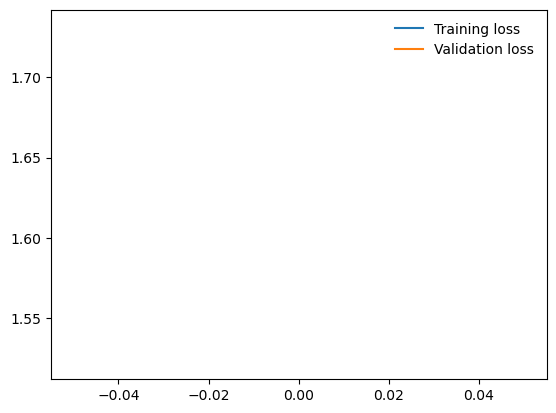

In [9]:
plt.plot(train_losses, label="Training loss")
plt.plot(test_losses, label="Validation loss")
plt.legend(frameon=False)

## Inference

In [10]:
def view_classify(img, ps, classes):
	''' Function for viewing an image and its predicted classes. '''

	# If `img` is flattened, reshape it to (3, 32, 32) for CIFAR-10 images
	if img.dim() == 2 or img.shape[1] == 3 * 32 * 32:  # Adjust size for your dataset
		img = img.view(3, 32, 32)

	# Permute dimensions to make it compatible with plt.imshow
	img = img.permute(1, 2, 0)  # [C, H, W] -> [H, W, C]
	img = (img - img.min()) / (img.max() - img.min())  # Normalize for display

	# Convert prediction tensor to numpy for plotting
	ps = ps.data.numpy().squeeze()

	# Plot the image and the class probabilities
	fig, (ax1, ax2) = plt.subplots(figsize=(6, 9), ncols=2)
	ax1.imshow(img.numpy())
	ax1.axis("off")

	ax2.barh(np.arange(len(classes)), ps)
	ax2.set_aspect(0.1)
	ax2.set_yticks(np.arange(len(classes)))
	ax2.set_yticklabels(classes, size="small")
	ax2.set_title("Class probability")
	ax2.set_xlim(0, 1.1)

	plt.tight_layout()
	plt.show()

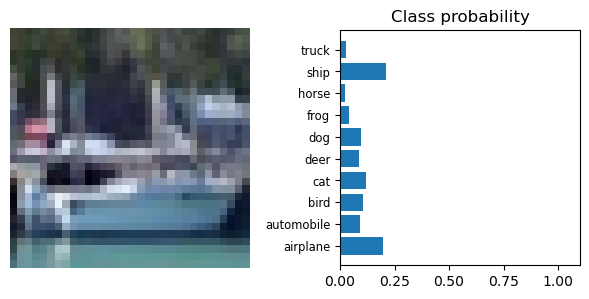

In [11]:
network.eval()

dataiter = iter(testloader)
images, labels = next(dataiter)
img = images[0].view(1, -1)

# Calculate the class probabilities (softmax) for img
with torch.no_grad():
	output = network.forward(img)

ps = torch.exp(output)

# Plot the image and probabilities
view_classify(img, ps, classes)

## Saving the network

In [ ]:
torch.save(network.state_dict(), "checkpoint.pth")